In [1]:
import os
import sys
import subprocess
# sys.path.insert(1, f"{subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')}/logistics/tools")
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, endf_tools
import numpy as np
# import openmc
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
# from tools import image_to_thesis
# image_to_thesis.pull_from_thesis()


v3 - MT2


100%|██████████| 500/500 [00:01<00:00, 307.18it/s]


v3 - MT16


100%|██████████| 500/500 [00:01<00:00, 325.20it/s]


v3 - MT22


100%|██████████| 500/500 [00:01<00:00, 302.73it/s]


v3 - MT28


100%|██████████| 500/500 [00:01<00:00, 310.03it/s]


v3 - MT51


100%|██████████| 500/500 [00:01<00:00, 323.13it/s]


v3 - MT52


100%|██████████| 500/500 [00:01<00:00, 281.71it/s]


v3 - MT102


100%|██████████| 500/500 [00:01<00:00, 296.11it/s]


v3 - MT103


100%|██████████| 500/500 [00:01<00:00, 261.06it/s]


v3 - MT104


100%|██████████| 500/500 [00:01<00:00, 322.40it/s]


v3 - MT105


100%|██████████| 500/500 [00:01<00:00, 282.40it/s]


v3 - MT107


100%|██████████| 500/500 [00:01<00:00, 253.22it/s]


<Figure size 640x480 with 0 Axes>

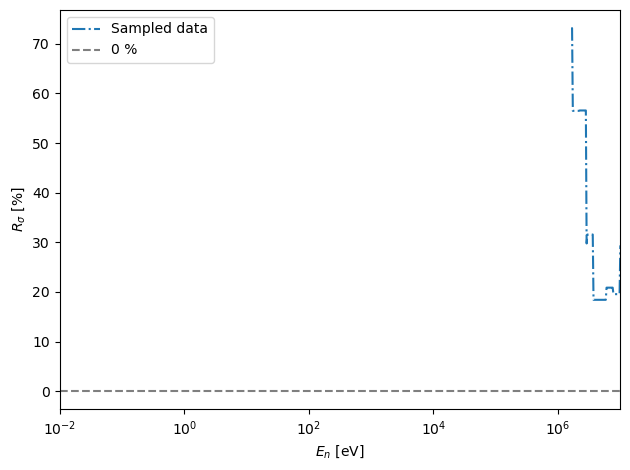

In [8]:
TEMPERATURE = 900 # K
N_ITERATIONS = 500

for MT_INT in [2, 16, 22, 28, 51, 52, 102, 103, 104, 105, 107]:
# for MT_INT in [2]:
# for MT_INT in [2]:
    MT_STRING = f"{MT_INT:03d}"

    res_folder = f"results/MT{MT_INT}"
    os.system(f"rm -rf {res_folder}")
    os.makedirs(res_folder, exist_ok=True)

    # df_v1 = pd.DataFrame(columns=["energy", "xs"])
    df_v3 = pd.DataFrame(columns=["energy", "xs"])

    for VERSION in ["v3"]:
        print(f"{VERSION} - MT{MT_INT}")
        if VERSION == "v1":
            sampled_h5_files_path = "/home/fne23_stjarnholm/nuclear_data/sandy_samples_v1/hdf5/F19"
        elif VERSION == "v3":
            sampled_h5_files_path = "/home/fne23_stjarnholm/nuclear_data/sandy_samples_v3"

        

        x_logspace = np.logspace(np.log10(1e-5), np.log10(2e7), 1000)

        for i in tqdm(range(N_ITERATIONS)):
            h5_filename = f"{sampled_h5_files_path}/F19-{i+1}.h5"

            h5file = h5py.File(h5_filename, 'r')
            energy_group = h5file[f'F19/energy/{TEMPERATURE}K']
            reactions_group = h5file[f'F19/reactions']

            xs_group = reactions_group[f'reaction_{MT_STRING}/{TEMPERATURE}K/xs']

            # Extract the cross section and energy data
            xs = xs_group[:]
            if len(xs) != len(energy_group[:]):
                energy = energy_group[-len(xs):]
            else:
                energy = energy_group[:]
        
            # Interpolate the cross section to the desired energy grid
            xs = np.interp(x_logspace, energy, xs)
            energy = x_logspace

            if VERSION == "v1":
                df_v1 = pd.concat([df_v1, pd.DataFrame({"energy": energy, "xs": xs})], ignore_index=True)
            elif VERSION == "v3":
                df_v3 = pd.concat([df_v3, pd.DataFrame({"energy": energy, "xs": xs})], ignore_index=True)

    for df, VERSION in zip([df_v3], ["v3"]):
        MT_SUFFIX = f"-MT{MT_INT}"
        MT_STRING = f"{MT_INT:03d}"

        plt.clf()
        plt.figure()
        ax = plt.gca()

        sns.lineplot(data=df, x="energy", y="xs", errorbar=('pi', 100), linewidth=0, label='_nolegend_')
        sns.lineplot(data=df, x="energy", y="xs", errorbar=('pi', 50), linewidth=0, label="_nolegend_")
        sns.lineplot(data=df, x="energy", y="xs", errorbar=None, linewidth=0.5, label="")
        plt.xscale("log")
        plt.yscale("log")

        ax.set_xlabel("$E_n$ [eV]")
        ax.set_ylabel("Cross section [b]")
        # ax.set_title(f"Sampled {endf_tools.MT_to_label(MT_INT, short=True)} (MT{MT_INT}) cross section\nfrom {N_ITERATIONS} samples for F-19")
        # plt.legend(['Mean', '50 % percentile interval', '90 % percentile interval', '100 % percentile interval'])
        plt.xlim(1e-2, 1e7)
        plt.legend(['100 % percentile interval', '50 % percentile interval', 'Mean'])
        plt.tight_layout()

        plt.savefig(f"{res_folder}/errorbands_sampled_cross_section_plot_{VERSION}_{MT_STRING}.pdf")
        plt.savefig(f"{res_folder}/errorbands_sampled_cross_section_plot_{VERSION}_{MT_INT}.pdf")

        plt.close('all')





    # Get the mean and standard deviation of the cross sections
    # df_v1_mean = df_v1.groupby("energy").mean().reset_index()
    # df_v1_std = df_v1.groupby("energy").std().reset_index()
    df_v3_mean = df_v3.groupby("energy").mean().reset_index()
    df_v3_std = df_v3.groupby("energy").std().reset_index()

    # # Plot the mean and standard deviation of the cross sections
    # plt.clf()
    # plt.figure()
    # ax = plt.gca()

    # sns.lineplot(data=df_v1_mean, x="energy", y="xs", label="v1")
    # sns.lineplot(data=df_v3_mean, x="energy", y="xs", label="v3", linestyle="--")
    # plt.xscale("log")
    # plt.yscale("log")

    # ax.set_xlabel("$E_n$ [eV]")
    # ax.set_ylabel("Cross section [b]")
    # ax.set_title(f"Mean sampled {endf_tools.MT_to_label(MT_INT, short=True)} cross section\nfrom {N_ITERATIONS} samples for F-19")
    # plt.legend()
    # plt.tight_layout()

    # plt.savefig(f"{res_folder}/mean_sampled_cross_section_plot_{MT_STRING}.pdf")





    # # Plot the means subtracted from each other
    # plt.clf()
    # plt.figure()
    # ax = plt.gca()

    # # Subtract the mean of v3 from the mean of v1
    # df_mean_diff = df_v1_mean.copy()
    # df_mean_diff["xs"] = df_v1_mean["xs"] - df_v3_mean["xs"]

    # sns.lineplot(data=df_mean_diff, x="energy", y="xs", label="v1 - v3")
    # plt.xscale("log")
    # plt.yscale("log")

    # ax.set_xlabel("$E_n$ [eV]")
    # ax.set_ylabel("Cross section [b]")
    # ax.set_title(f"Difference in mean sampled {endf_tools.MT_to_label(MT_INT, short=True)} cross section\nfrom {N_ITERATIONS} samples for F-19")

    # plt.legend()
    # plt.tight_layout()

    # plt.savefig(f"{res_folder}/mean_diff_sampled_cross_section_plot_{MT_STRING}.pdf")




    # # Plot the means subtracted from each other, divided by the mean in each energy bin
    # plt.clf()
    # plt.figure()
    # ax = plt.gca()

    # # Subtract the mean of v3 from the mean of v1 and divide by the mean of v3
    # df_mean_diff = df_v1_mean.copy()
    # df_mean_diff["xs"] = df_v1_mean["xs"] - df_v3_mean["xs"]
    # df_mean_diff["rel"] = df_mean_diff["xs"] / df_v3_mean["xs"] * 100

    # sns.lineplot(data=df_mean_diff, x="energy", y="rel", label="v1 - v3")
    # plt.xscale("log")
    # # plt.yscale("log")

    # plt.axhline(0, color="tab:gray", linestyle="dashed", label="0 %")
    # # plt.xlim(min(df_mean_diff["energy"]), max(df_mean_diff["energy"]))

    # ax.set_xlabel("$E_n$ [eV]")
    # ax.set_ylabel("Relative difference in cross section means (%)")
    # ax.set_title(f"Relative difference in mean sampled {endf_tools.MT_to_label(MT_INT, short=True)} cross section\nfrom {N_ITERATIONS} samples for F-19")

    # plt.legend()
    # plt.tight_layout()

    # plt.savefig(f"{res_folder}/relative_mean_diff_sampled_cross_section_plot_{MT_STRING}.pdf")




    # Calculate the relative error and plot it for the two versions
    # df_v1_std["rel"] = df_v1_std["xs"] / df_v1_mean["xs"] * 100
    df_v3_std["rel"] = df_v3_std["xs"] / df_v3_mean["xs"] * 100

    plt.clf()
    plt.figure()
    ax = plt.gca()

    # sns.lineplot(data=df_v1_std, x="energy", y="rel", label="v1")
    sns.lineplot(data=df_v3_std, x="energy", y="rel", label="Sampled data", linestyle="-.")
    plt.xscale("log")
    # plt.yscale("log")

    plt.axhline(0, color="tab:gray", linestyle="dashed", label="0 %")
    # plt.xlim(min(df_v1_std["energy"]), max(df_v1_std["energy"]))

    ax.set_xlabel("$E_n$ [eV]")
    ax.set_ylabel("$R_{\sigma}$ [%]")
    # ax.set_title(f"Relative error, sampled {endf_tools.MT_to_label(MT_INT, short=True)} (MT{MT_INT}) cross section\nfrom {N_ITERATIONS} samples for F-19")
    plt.xlim(1e-2, 1e7)
    plt.legend()
    plt.tight_layout()

    plt.savefig(f"{res_folder}/relative_error_cross_section_plot_{MT_STRING}.pdf")
    plt.savefig(f"{res_folder}/relative_error_cross_section_plot_{MT_INT}.pdf")


